In [1]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [15]:
import torch
import torch.nn as nn
import numpy as np

In [48]:
class ColorEncoder(nn.Module):
    
    def __init__(self, color_dim, hidden_dim):
        super(ColorEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.color_dim = color_dim
        self.color_lstm = nn.LSTM(color_dim, hidden_dim, batch_first=True)

    def forward(self, colors):
        """
        Colors should be in order with target LAST
        """
        color_states = self.init_hidden_and_context()
        color_output, (hn, cn) = self.color_lstm(colors, color_states)
        # target is last - return hidden representation, why not context i have no idea
        return hn

    def init_hidden_and_context(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
       

In [237]:
class Speaker(nn.Module):
    
    def __init__(self, color_dim, vocab_size, embed_dim, speaker_hidden_dim):
        super(Speaker, self).__init__()
        
        # self.color_encoder = ColorEncoder(color_in_dim, color_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.speaker_lstm = nn.LSTM(embed_dim + color_dim, speaker_hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        
        self.hidden_dim = speaker_hidden_dim
        
    def forward(self, color_features, captions):
        # all teacher forcing during training
        embeds = self.embed(captions)
        #print("Embed Shape:", embeds.shape)
        
        color_features = color_features.repeat(1, captions.shape[1], 1) # repeat for number of tokens
        
        inputs = torch.cat((embeds, color_features), dim=2) # cat along the innermost dimension
        #print("Input Shape:", inputs.shape)
        hiddens, _ = self.speaker_lstm(inputs) # hidden and context default to 0
        #print("Hiddens Shape:", hiddens.shape)
        outputs = self.linear(hiddens)
        #print("Outputs Shape:", outputs.shape)
        output_norm = self.logsoftmax(outputs)
        return output_norm
        
    def sample(self, color_features, caption_init):
        
        for i in range(self.max_gen_len):
        vocab_preds = lit_speaker(color_hidden, tokens)[:,-1:,:]
        _, prediction_index = vocab_preds.max(2)
        tokens = torch.cat((tokens, prediction_index), dim=1)
        if prediction_index.item() == end_index:
            break
        
        # caption init should just be a tensor with the start token index
        sampled_ids = []
        start_embed = self.embed(caption_init)
        start_input = torch.cat((start_embed, color_features), dim=2)
        context_and_hidden = (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))
        
        for i in range(20): # max seq length
            output, context_and_hidden = self.speaker_lstm(start_input, context_and_hidden)
            output = self.linear(output[-1])
            _, predicted_id = output.max(1)
            
            
        
        

In [156]:
from monroe_data import MonroeData, MonroeDataEntry, Color
from color_featurizers import ColorFeaturizer, color_phi_fourier
from caption_featurizers import CaptionFeaturizer

In [5]:
color_phi = ColorFeaturizer(color_phi_fourier, "rgb")

In [7]:
monroe_data_train = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")

In [43]:
train_colors_test = color_phi.to_color_features(monroe_data_train[0].colors)
train_colors_test = np.flip(train_colors_test, axis=0) # flip bc that's how monroe does it
train_colors_test = train_colors_test.copy() # to remove 'negative stride' error
train_colors_test_tensor = torch.tensor([train_colors_test]) 

In [44]:
train_colors_test_tensor

tensor([[[ 1.0000e+00, -9.9248e-01,  9.7003e-01,  9.9248e-01, -1.0000e+00,
           9.9248e-01,  9.7003e-01, -9.9248e-01,  1.0000e+00,  8.7009e-01,
          -9.2388e-01,  9.6378e-01,  8.0321e-01, -8.7009e-01,  9.2388e-01,
           7.2425e-01, -8.0321e-01,  8.7009e-01,  5.1410e-01, -6.1523e-01,
           7.0711e-01,  4.0524e-01, -5.1410e-01,  6.1523e-01,  2.9028e-01,
          -4.0524e-01,  5.1410e-01,  0.0000e+00, -1.2241e-01,  2.4298e-01,
          -1.2241e-01, -1.2246e-16,  1.2241e-01, -2.4298e-01,  1.2241e-01,
           0.0000e+00, -4.9290e-01,  3.8268e-01, -2.6671e-01, -5.9570e-01,
           4.9290e-01, -3.8268e-01, -6.8954e-01,  5.9570e-01, -4.9290e-01,
          -8.5773e-01,  7.8835e-01, -7.0711e-01, -9.1421e-01,  8.5773e-01,
          -7.8835e-01, -9.5694e-01,  9.1421e-01, -8.5773e-01],
         [ 1.0000e+00, -9.7832e-01,  9.1421e-01,  9.7832e-01, -1.0000e+00,
           9.7832e-01,  9.1421e-01, -9.7832e-01,  1.0000e+00, -5.5557e-01,
           3.7132e-01, -1.7096e-01, -

In [45]:
color_dim = 54
hidden_dim = 100

In [49]:
color_encoder = ColorEncoder(color_dim, hidden_dim)

In [51]:
color_features = color_encoder(train_colors_test_tensor)

In [88]:
color_features

tensor([[[-0.1658, -0.1022, -0.1696, -0.0378,  0.0271, -0.0811,  0.1505,
          -0.0862, -0.0571, -0.0744,  0.0032,  0.0606,  0.0461, -0.0845,
          -0.0107,  0.0941,  0.0240, -0.0369,  0.0395, -0.0872,  0.0600,
           0.0456, -0.0721, -0.1023,  0.0444, -0.0395,  0.0922,  0.0431,
           0.0026, -0.0514, -0.0832, -0.0195, -0.1460, -0.0261, -0.0333,
          -0.0032,  0.2056, -0.1198,  0.0398,  0.0455, -0.0086,  0.0075,
           0.0859, -0.0773, -0.1994,  0.0910,  0.0444, -0.0058, -0.0405,
          -0.0457,  0.1161,  0.0155,  0.0046,  0.0096, -0.1006, -0.0037,
          -0.1709,  0.0113,  0.0774,  0.0649, -0.0717, -0.1176, -0.0458,
           0.1057, -0.0950,  0.0018,  0.1442,  0.1369, -0.0661,  0.0080,
          -0.1698,  0.1032,  0.0675, -0.0959,  0.0378,  0.0423, -0.0997,
          -0.0509, -0.0090, -0.0861,  0.0369,  0.0457, -0.1105,  0.0781,
           0.1225, -0.0491,  0.0774, -0.0174,  0.0240,  0.1001,  0.0759,
          -0.0863, -0.1642, -0.1159,  0.0334, -0.05

In [109]:
color_featurs_rpt = color_features.repeat(1, 6, 1)

In [89]:
test_embed = nn.Embedding(20, 100)

In [96]:
test_caption_embed = test_embed(train_caption_test_tensor) # batch size x seq_len x embed dim

In [110]:
test_joint_embed = torch.cat((color_featurs_rpt, test_caption_embed), dim=2)

In [111]:
test_joint_embed.shape

torch.Size([1, 6, 200])

In [103]:
test_joint_embed.shape

torch.Size([1, 7, 100])

In [95]:
#test_embed(train_caption_test_tensor_v2).shape # not when batch_first is true

torch.Size([6, 1, 100])

In [155]:
import importlib
import caption_featurizers
importlib.reload(caption_featurizers)

<module 'caption_featurizers' from '../caption_featurizers.py'>

In [157]:
caption_phi = CaptionFeaturizer()
caption_phi.construct_featurizer(monroe_data_train)

In [68]:
monroe_data_train[0].caption

'The darker blue one'

In [70]:
_, train_caption_test = caption_phi.to_string_features(monroe_data_train[0].caption)

In [71]:
train_caption_test

array([0, 1, 2, 3, 4, 5])

In [74]:
train_caption_test_tensor = torch.tensor([train_caption_test], dtype=torch.long)

In [75]:
train_caption_test_tensor

tensor([[0, 1, 2, 3, 4, 5]])

In [92]:
train_caption_test_tensor_v2 = train_caption_test_tensor.view(-1, 1)

In [124]:
caption_phi.caption_indexer.size

6

In [238]:
embed_dim = 100
color_embed_dim = 100
lit_speaker = Speaker(color_embed_dim, caption_phi.caption_indexer.size, embed_dim, hidden_dim)

In [162]:
test_output = lit_speaker(color_features, train_caption_test_tensor)

Embed Shape: torch.Size([1, 6, 100])
Input Shape: torch.Size([1, 6, 200])
Hiddens Shape: torch.Size([1, 6, 100])
Outputs Shape: torch.Size([1, 6, 1026])


In [132]:
test_output = torch.tensor([[[ 0.0277, -0.1126,  0.1665, -0.0175, -0.0271,  0.1332],
         [-0.1007, -0.0795,  0.1356, -0.0220, -0.0995,  0.0179],
         [-0.0856, -0.0679,  0.1927, -0.0224, -0.0225,  0.0786],
         [ 0.0892, -0.1054,  0.1166,  0.1385,  0.0678, -0.0863],
         [ 0.0178, -0.1882,  0.1608,  0.0925, -0.0561,  0.0705],
         [ 0.0131, -0.2336,  0.0719, -0.0714, -0.0005,  0.0543]]])

In [160]:
test_output = nn.functional.softmax(test_output, dim=1)

In [165]:
test_output.shape

torch.Size([1, 6, 1026])

In [166]:
test_output[:,:-1,:].shape

torch.Size([1, 5, 1026])

In [150]:
sum(np.exp([-1.8621, -1.7997, -1.8290, -1.8715, -1.6569, -1.7480]))

1.0000124220102928

In [145]:
0.1721+0.1513+0.1536+0.1830+0.1704+0.1696

0.9999999999999999

In [143]:
sum([0.1658, 0.1441, 0.1905, 0.1585, 0.1569, 0.1842])

1.0

In [141]:
sum([0.1721, 0.1695, 0.1709, 0.1607, 0.1658, 0.1817])

1.0207

In [55]:
import matplotlib.pyplot as plt

In [56]:
%matplotlib inline

2) Game: 1124-1 Round: 3
Medium pink ~ the medium dark one


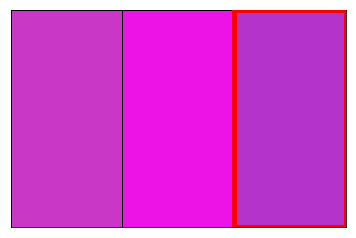

In [60]:
monroe_data_train.display_game(2)

In [ ]:
caption_phi = CaptionFeaturizer()
caption_phi.construct_featurizer(monroe_data_train)

In [ ]:
for data_entry in monroe_data_train:
    caption_features = caption_phi.to_string_features(data_entry.caption)
    color_features = color_phi.to_color_features(data_entry.colors)
    # turn them into torch tensors

In [171]:
train_caption_test

array([0, 1, 2, 3, 4, 5])

In [169]:
targets = train_caption_test[1:]

In [207]:
targets_tensor = torch.tensor(targets)

In [208]:
targets_tensor

tensor([1, 2, 3, 4, 5])

In [172]:
color_features.shape

torch.Size([1, 1, 100])

In [173]:
color_features

tensor([[[-0.1658, -0.1022, -0.1696, -0.0378,  0.0271, -0.0811,  0.1505,
          -0.0862, -0.0571, -0.0744,  0.0032,  0.0606,  0.0461, -0.0845,
          -0.0107,  0.0941,  0.0240, -0.0369,  0.0395, -0.0872,  0.0600,
           0.0456, -0.0721, -0.1023,  0.0444, -0.0395,  0.0922,  0.0431,
           0.0026, -0.0514, -0.0832, -0.0195, -0.1460, -0.0261, -0.0333,
          -0.0032,  0.2056, -0.1198,  0.0398,  0.0455, -0.0086,  0.0075,
           0.0859, -0.0773, -0.1994,  0.0910,  0.0444, -0.0058, -0.0405,
          -0.0457,  0.1161,  0.0155,  0.0046,  0.0096, -0.1006, -0.0037,
          -0.1709,  0.0113,  0.0774,  0.0649, -0.0717, -0.1176, -0.0458,
           0.1057, -0.0950,  0.0018,  0.1442,  0.1369, -0.0661,  0.0080,
          -0.1698,  0.1032,  0.0675, -0.0959,  0.0378,  0.0423, -0.0997,
          -0.0509, -0.0090, -0.0861,  0.0369,  0.0457, -0.1105,  0.0781,
           0.1225, -0.0491,  0.0774, -0.0174,  0.0240,  0.1001,  0.0759,
          -0.0863, -0.1642, -0.1159,  0.0334, -0.05

In [174]:
predictions = lit_speaker(color_features, train_caption_test_tensor)

Embed Shape: torch.Size([1, 6, 100])
Input Shape: torch.Size([1, 6, 200])
Hiddens Shape: torch.Size([1, 6, 100])
Outputs Shape: torch.Size([1, 6, 1026])


In [177]:
predictions = predictions[:,:-1,:]

In [179]:
predictions.shape

torch.Size([1, 5, 1026])

In [192]:
predictions_squeeze = predictions.squeeze(0)

In [193]:
predictions_squeeze

tensor([[-6.9851, -6.9951, -7.0918,  ..., -7.0591, -6.9044, -6.9136],
        [-6.9592, -7.0131, -7.0628,  ..., -6.9723, -6.8610, -6.9665],
        [-7.0227, -6.9164, -6.9528,  ..., -7.0429, -6.9906, -6.7736],
        [-7.1074, -6.9282, -7.0202,  ..., -7.0575, -6.9063, -6.7328],
        [-7.0327, -6.9017, -6.9920,  ..., -7.1274, -7.0435, -6.7871]],
       grad_fn=<SqueezeBackward1>)

In [206]:
predictions

tensor([[[-6.9851, -6.9951, -7.0918,  ..., -7.0591, -6.9044, -6.9136],
         [-6.9592, -7.0131, -7.0628,  ..., -6.9723, -6.8610, -6.9665],
         [-7.0227, -6.9164, -6.9528,  ..., -7.0429, -6.9906, -6.7736],
         [-7.1074, -6.9282, -7.0202,  ..., -7.0575, -6.9063, -6.7328],
         [-7.0327, -6.9017, -6.9920,  ..., -7.1274, -7.0435, -6.7871]]],
       grad_fn=<SliceBackward>)

In [197]:
test_criterion = nn.NLLLoss()

In [209]:
test_criterion(predictions_squeeze, targets_tensor)

tensor(7.0452, grad_fn=<NllLossBackward>)

In [213]:
test_optimer = torch.optim.Adam(lr=0.004, params=lit_speaker.parameters())

In [217]:
train_iter(color_encoder, lit_speaker, train_caption_test_tensor, train_colors_test_tensor, targets_tensor,
          test_optimer, test_criterion)

Embed Shape: torch.Size([1, 6, 100])
Input Shape: torch.Size([1, 6, 200])
Hiddens Shape: torch.Size([1, 6, 100])
Outputs Shape: torch.Size([1, 6, 1026])


tensor(7.0452, grad_fn=<AddBackward0>)

In [223]:
features = []
targets = []
for data_entry in monroe_data_train:
    _, caption_features = caption_phi.to_string_features(data_entry.caption)
    color_features = color_phi.to_color_features(data_entry.colors)
    # reverse color order
    color_features = np.flip(color_features, axis=0).copy()
    features.append((caption_features, color_features))
    targets.append(caption_features[1:])

In [225]:
features[0]

(array([0, 1, 2, 3, 4, 5]),
 array([[ 1.0000000e+00, -9.9247956e-01,  9.7003126e-01,  9.9247956e-01,
         -1.0000000e+00,  9.9247956e-01,  9.7003126e-01, -9.9247956e-01,
          1.0000000e+00,  8.7008697e-01, -9.2387950e-01,  9.6377605e-01,
          8.0320752e-01, -8.7008697e-01,  9.2387950e-01,  7.2424710e-01,
         -8.0320752e-01,  8.7008697e-01,  5.1410276e-01, -6.1523157e-01,
          7.0710677e-01,  4.0524131e-01, -5.1410276e-01,  6.1523157e-01,
          2.9028466e-01, -4.0524131e-01,  5.1410276e-01,  0.0000000e+00,
         -1.2241068e-01,  2.4298018e-01, -1.2241068e-01, -1.2246469e-16,
          1.2241068e-01, -2.4298018e-01,  1.2241068e-01,  0.0000000e+00,
         -4.9289820e-01,  3.8268343e-01, -2.6671275e-01, -5.9569931e-01,
          4.9289820e-01, -3.8268343e-01, -6.8954057e-01,  5.9569931e-01,
         -4.9289820e-01, -8.5772860e-01,  7.8834641e-01, -7.0710677e-01,
         -9.1420978e-01,  8.5772860e-01, -7.8834641e-01, -9.5694035e-01,
          9.1420978e-01

In [214]:
def train_iter(color_encoder, caption_generator, caption_tensor, color_tensor, target, optimizer, criterion):
    """
    Iterates through a single training pair, querying the model, getting a loss and
    updating the parameters. (TODO: addd some kind of batching to this).

    Very much inspired by the torch NMT example/tutorial thingy
    """
    # start_states = self.model.init_hidden_and_context()
    #input_length = caption_tensor.size(0)
    optimizer.zero_grad()
    loss = 0

    color_features = color_encoder(color_tensor)
    model_output = caption_generator(color_features, caption_tensor)

    # we don't care about the last prediction, because nothing follows the final </s> token
    model_output = model_output[:,:-1,:].squeeze(0) # go from 1 x seq_len x vocab_size => seq_len x vocab_size
                                                    # for calculating loss function:
                                                    # see here for details when implementing batching
                                                    # https://discuss.pytorch.org/t/calculating-loss-for-entire-batch-using-nllloss-in-0-4-0/17142/7

    # targets should be caption without start index: i.e. [the blue one </s>] so we can predict
    # next tokens from input like [<s> the blue one]

    loss += criterion(model_output, target)
    loss.backward()
    optimizer.step()

    return loss

In [239]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [240]:
def train_model(features, targets, optimizer, criterion, num_epochs, color_encoder, caption_generator, lr=0.004):


    optimizer = optimizer(lr=lr, params=list(color_encoder.parameters()) + list(caption_generator.parameters()))
    criterion = criterion()
    start_time = time.time()
    store_losses_every = 100
    print_losses_every = 1000
    stored_losses = [] # theoretically we store losses so we can plot them later - 
                            # I don't think this part of the code works though. What we
                            # can do instead is take a few thousand or so training examples
                            # out and use them for "evaluation" every 1 epoch or so
    for epoch in range(num_epochs):
        print("---EPOCH {}---".format(epoch))
        stored_loss_total = 0
        print_loss_total = 0

        for i, pair in enumerate(features):
            caption, colors = pair
            caption = torch.tensor([caption], dtype=torch.long)
            colors = torch.tensor([colors], dtype=torch.float)
            # this was changed
            target = torch.tensor(targets[i]) # already turned it into a tensor in `self.fit`


            loss = train_iter(color_encoder, caption_generator, caption, colors, target, optimizer, criterion)
            stored_loss_total += loss.item()
            print_loss_total += loss.item()

            if i % print_losses_every == 0:
                print_loss_avg = print_loss_total / print_losses_every
                print("{} ({}:{} {:.2f}%) {:.4f}".format(asMinutes(time.time() - start_time),
                                                  epoch, i, i/len(features)*100,
                                                  print_loss_avg))
                print_loss_total = 0

            if i % store_losses_every == 0:
                stored_loss_avg = stored_loss_total / store_losses_every
                stored_losses.append(stored_loss_avg)
                stored_loss_total = 0

In [241]:
optimizer = torch.optim.Adam
criterion = nn.NLLLoss
epochs = 5

train_model(features, targets, optimizer, criterion, epochs, color_encoder, lit_speaker, lr=0.004)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0069
0m 5s (0:1000 6.38%) 3.0628
0m 12s (0:2000 12.77%) 3.0255
0m 19s (0:3000 19.15%) 3.2140
0m 26s (0:4000 25.53%) 3.0905
0m 34s (0:5000 31.92%) 3.3288
0m 42s (0:6000 38.30%) 2.8381
0m 50s (0:7000 44.69%) 2.5258
0m 59s (0:8000 51.07%) 2.8705
1m 8s (0:9000 57.45%) 2.3008
1m 17s (0:10000 63.84%) 2.4063
1m 26s (0:11000 70.22%) 2.1981
1m 35s (0:12000 76.60%) 2.2217
1m 44s (0:13000 82.99%) 2.4715
1m 54s (0:14000 89.37%) 2.4886
2m 3s (0:15000 95.75%) 2.8288
---EPOCH 1---
2m 10s (1:0 0.00%) 0.0015
2m 19s (1:1000 6.38%) 2.2457
2m 29s (1:2000 12.77%) 2.6647
2m 39s (1:3000 19.15%) 2.8676
2m 49s (1:4000 25.53%) 2.8568
2m 59s (1:5000 31.92%) 3.1168
3m 9s (1:6000 38.30%) 2.5957
3m 19s (1:7000 44.69%) 2.2874
3m 29s (1:8000 51.07%) 2.6781
3m 40s (1:9000 57.45%) 2.1543
3m 50s (1:10000 63.84%) 2.2300
4m 0s (1:11000 70.22%) 2.0911
4m 11s (1:12000 76.60%) 2.0938
4m 22s (1:13000 82.99%) 2.3372
4m 33s (1:14000 89.37%) 2.3387
4m 44s (1:15000 95.75%) 2.6998
---EPOCH 2---
4m

In [251]:
_, start_end_tokens = caption_phi.to_string_features("")
start_token = start_end_tokens[:1]


In [279]:
start_token_tensor = torch.tensor([start_token])

In [280]:
start_token_tensor

tensor([[0]])

In [277]:
start_token_tensor.shape[1]

1

In [261]:
color_features = color_phi.to_color_features(monroe_data_train[0].colors)
color_features = np.flip(color_features).copy()

In [268]:
color_features_tensor = torch.tensor([color_features])

In [278]:
color_features_tensor

torch.Size([1, 3, 54])

In [270]:
with torch.no_grad():
    color_hidden = color_encoder(color_features_tensor)

In [271]:
color_hidden

tensor([[[-5.8963e-11,  1.4735e-03,  1.3294e-08, -1.4023e-09,  8.2325e-11,
           3.3685e-17,  1.2891e-01, -1.3805e-02, -1.7243e-05, -7.6492e-01,
          -2.4686e-04,  5.3317e-08,  6.1667e-03, -9.9964e-05, -6.9311e-01,
          -1.5405e-10, -4.1267e-12,  4.0509e-01,  6.9762e-18, -6.5709e-11,
          -4.6384e-15,  9.9269e-01,  1.8415e-02,  4.9983e-05,  2.0152e-02,
           9.6281e-01,  5.2528e-09,  1.6348e-10,  1.3820e-01,  2.6305e-01,
          -7.5883e-01, -7.3660e-01, -1.2099e-03, -6.4656e-06, -3.9381e-01,
           2.7583e-05,  1.9473e-05,  1.0987e-02,  4.3957e-01, -7.6060e-01,
          -4.3767e-10,  4.8078e-07, -6.0415e-01, -7.5754e-01, -3.5695e-05,
           5.5961e-01, -7.8295e-08,  5.9885e-17, -1.9891e-03, -4.3265e-08,
          -2.9429e-05, -1.3059e-07,  2.3924e-10,  1.2350e-07,  5.4578e-07,
          -7.6108e-01,  9.5138e-04,  1.9278e-04,  5.6679e-10, -4.0206e-01,
          -5.6103e-07,  2.8893e-07,  1.2813e-01, -7.6079e-01,  2.9734e-05,
          -7.6151e-10, -4

In [281]:
with torch.no_grad():
    vocab_preds = lit_speaker(color_hidden, start_token_tensor)

In [283]:
vocab_preds.shape

torch.Size([1, 1, 1026])

In [290]:
_, prediction_index = vocab_preds.max(2)

In [291]:
prediction_index

tensor([[1]])

In [305]:
tokens = start_token_tensor

In [306]:
tokens = torch.cat((tokens, prediction_index), dim=1)

In [307]:
tokens

tensor([[0, 1]])

In [319]:
with torch.no_grad():
    vocab_preds = lit_speaker(color_hidden, tokens)[:,-1:,:]

In [321]:
_, prediction_index = vocab_preds.max(2)

In [322]:
prediction_index

tensor([[4]])

In [311]:
vocab_preds.max(2)

(tensor([[-1.8698, -2.1367]]), tensor([[1, 4]]))

In [323]:
tokens = torch.cat((tokens, prediction_index), dim=1)

In [340]:
tokens[:,-1:].item()

5

In [325]:
_, start_end_tokens = caption_phi.to_string_features("")
start_token = start_end_tokens[:1]
tokens = torch.tensor([start_token])

with torch.no_grad():
    color_hidden = color_encoder(color_features_tensor)
    
with torch.no_grad():
    for i in range(self.max_gen_len):
        vocab_preds = lit_speaker(color_hidden, tokens)[:,-1:,:]
        _, prediction_index = vocab_preds.max(2)
        tokens = torch.cat((tokens, prediction_index), dim=1)
        if prediction_index.item() == end_index:
            break

In [333]:
np.argmax([len(de.tokens) for de in monroe_data_train])

12980

12980) Game: 6089-c Round: 3
yes, caca green, brown caca, barney? ~ thank you. i take it your a bread on a certain forum ~ ahhhh. bummer, i saw someone talk about having a great partner on a forum ~ let's see how we can get through this. then hopefully we will meet again ~ thank you. you were awesome too ~ grey


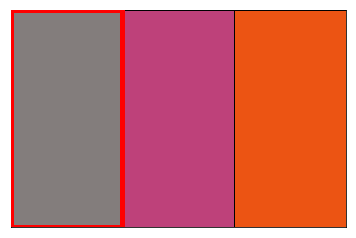

In [334]:
monroe_data_train.display_game(12980)

In [326]:
tokens

tensor([[0, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]])

In [327]:
caption_phi.caption_indexer.get_word_from_idx(0)

'<sos>'

In [328]:
caption_phi.caption_indexer.get_word_from_idx(1)

'the'

In [329]:
caption_phi.caption_indexer.get_word_from_idx(4)

'one'

In [330]:
caption_phi.caption_indexer.get_word_from_idx(5)

'<eos>'

In [233]:
import time
import math

In [ ]:
class LiteralSpeaker():


    def fit(self, X, y):
        self.features = X
        self.targets = torch.tensor([y])
        self.train_model()

    def predict(self, X):
        """
        Produces and tracks model outputs
        """
        self.model.eval()
        model_outputs = np.empty([len(X), 3])

        for i, feature in enumerate(X):
            caption, colors = feature
            caption = torch.tensor(caption, dtype=torch.long).view(-1, 1)
            colors = torch.tensor(colors, dtype=torch.float)
            model_output_np = self.evaluate_iter((caption, colors)).view(-1).numpy()
            model_outputs[i] = model_output_np

        return np.array(model_outputs)


    def __init__(self,  model, optimizer=torch.optim.Adadelta,
                 criterion=nn.NLLLoss, lr=0.2, num_epochs=30):
        """
        Right now this is kind of ugly because you have to pass literally all of the experiment arguments
        to this constructor. 
        """

        self.model = model

        self.optimizer = optimizer
        self.criterion = criterion

        # misc args:
        self.lr = lr
        self.num_epochs = num_epochs

        # for reproducibility, store training pairs
        self.features  = None
        self.target = None

        # also make sure the model has been initialized before we do anything
        self.initialized = False


    # from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)


    def init_model(self, **model_params):
        """
        Interesting quirk - in most cases, the model takes the vocabulary size
        as an input, but there's no way for the user to know what the vocab
        size is before calling the init_model method. Even though it's kinda ugly,
        what we can do instead is pass all of the model params (named) minus
        the vocab size to this function, and it will create the model. I don't 
        really like this but it works for now
        """
        if self.initialized:
            return

        # self.caption_featurizer.construct_featurizer(self.train_data)
        # self.train_pairs = self.get_pairs(self.train_data, construct=True)
        # model_params['vocab_size'] = self.caption_featurizer.caption_indexer.size
        self.model = self.model(**model_params)
        self.initialized = True

    def train_iter(self, caption_tensor, color_tensor, target, optimizer, criterion):
        """
        Iterates through a single training pair, querying the model, getting a loss and
        updating the parameters. (TODO: addd some kind of batching to this).

        Very much inspired by the torch NMT example/tutorial thingy
        """
        # start_states = self.model.init_hidden_and_context()
        #input_length = caption_tensor.size(0)
        optimizer.zero_grad()
        loss = 0
        
        color_features = self.color_encoder(color_tensor)
        model_output = self.caption_generator(color_features, caption_tensor)
        
        # we don't care about the last prediction, because nothing follows the final </s> token
        model_output = model_output[:,:-1,:].squeeze(0) # go from 1 x seq_len x vocab_size => seq_len x vocab_size
                                                        # for calculating loss function:
                                                        # see here for details when implementing batching
                                                        # https://discuss.pytorch.org/t/calculating-loss-for-entire-batch-using-nllloss-in-0-4-0/17142/7
        
        # targets should be caption without start index: i.e. [the blue one </s>] so we can predict
        # next tokens from input like [<s> the blue one]

        loss += criterion(model_output, target)
        loss.backward()
        optimizer.step()

        return loss


    def train_model(self):
        if not self.initialized:
            print("Make sure you initialize the model with the parameters you want")
            return


        optimizer = self.optimizer(lr=self.lr, params=self.model.parameters())
        criterion = self.criterion()

        start_time = time.time()
        store_losses_every = 100
        print_losses_every = 1000
        self.stored_losses = [] # theoretically we store losses so we can plot them later - 
                                # I don't think this part of the code works though. What we
                                # can do instead is take a few thousand or so training examples
                                # out and use them for "evaluation" every 1 epoch or so
        for epoch in range(self.num_epochs):
            print("---EPOCH {}---".format(epoch))
            stored_loss_total = 0
            print_loss_total = 0

            for i, pair in enumerate(self.features):
                caption, colors = pair
                caption = torch.tensor(caption, dtype=torch.long).view(-1, 1)
                colors = torch.tensor(colors, dtype=torch.float)
                target = self.targets[i] # already turned it into a tensor in `self.fit`


                loss = self.train_iter(caption, colors, target, optimizer, criterion)
                stored_loss_total += loss.item()
                print_loss_total += loss.item()

                if i % print_losses_every == 0:
                    print_loss_avg = print_loss_total / print_losses_every
                    print("{} ({}:{} {:.2f}%) {:.4f}".format(self.asMinutes(time.time() - start_time),
                                                      epoch, i, i/len(self.features)*100,
                                                      print_loss_avg))
                    print_loss_total = 0

                if i % store_losses_every == 0:
                    stored_loss_avg = stored_loss_total / store_losses_every
                    self.stored_losses.append(stored_loss_avg)
                    stored_loss_total = 0


    def evaluate_iter(self, pair):
        """
        Same as train_iter except don't use an optimizer and gradients or anything
        like that
        """
        with torch.no_grad():
            caption_tensor, color_tensor = pair
            start_states = self.model.init_hidden_and_context()
            model_output, _, _ = self.model(caption_tensor, start_states, color_tensor)

            model_output = model_output.view(1, -1)
            return model_output


    def load_model(self, filename):
        """
        Load model from saved file at filename
        """
        if not self.initialized:
            self.init_model
        self.model.load_state_dict(torch.load(filename))

    def save_model(self, filename):
        """
        Save model to file at filename
        """
        torch.save(self.model.state_dict(), filename)


In [345]:
np.exp(-(np.log(0.333)))

3.003003003003003

In [346]:
# now let's evaluate on the dev set
monroe_data_dev = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [349]:
end_index = caption_phi.caption_indexer.get_idx_from_word(caption_phi.caption_indexer.EOS)

In [347]:
_, start_end_tokens = caption_phi.to_string_features("")
start_token = start_end_tokens[:1]


In [384]:
color_features_tensor = torch.tensor([np.flip(color_phi.to_color_features(monroe_data_dev[0].colors), axis=0).copy()])

In [386]:
with torch.no_grad():
    color_hidden = color_encoder(color_features_tensor)

tokens = torch.tensor([start_token])
with torch.no_grad():
    for i in range(20):
        vocab_preds = lit_speaker(color_hidden, tokens)[:,-1:,:]
        _, prediction_index = vocab_preds.max(2)
        tokens = torch.cat((tokens, prediction_index), dim=1)
        if prediction_index.item() == end_index:
            break

In [ ]:
caption_phi

In [387]:
tokens

tensor([[ 0, 16,  5]])

In [360]:
tokens.view(-1).numpy()

array([0, 3, 5])

In [366]:
def token_indices_to_words(tokens):
    tokens = tokens.view(-1)
    words = []
    for idx in tokens.numpy():
        words.append(
            caption_phi.caption_indexer.get_word_from_idx(idx)
        )
    return words

In [388]:
token_indices_to_words(tokens)

['<sos>', 'brown', '<eos>']

0) Game: 2641-2 Round: 1
gray


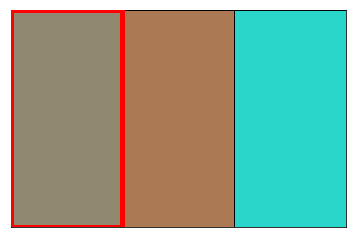

In [368]:
monroe_data_dev.display_game(0)

In [385]:
color_features_tensor

tensor([[[ 1.0000e+00, -7.8835e-01,  2.4298e-01, -8.7009e-01,  3.8268e-01,
           2.6671e-01,  5.1410e-01,  1.2241e-01, -7.0711e-01,  8.7009e-01,
          -9.8918e-01,  6.8954e-01, -1.0000e+00,  7.8835e-01, -2.4298e-01,
           8.7009e-01, -3.8268e-01, -2.6671e-01,  5.1410e-01, -9.3299e-01,
           9.5694e-01, -8.7009e-01,  9.8918e-01, -6.8954e-01,  1.0000e+00,
          -7.8835e-01,  2.4298e-01,  0.0000e+00, -6.1523e-01,  9.7003e-01,
          -4.9290e-01,  9.2388e-01, -9.6378e-01,  8.5773e-01, -9.9248e-01,
           7.0711e-01, -4.9290e-01, -1.4673e-01,  7.2425e-01, -1.2246e-16,
           6.1523e-01, -9.7003e-01,  4.9290e-01, -9.2388e-01,  9.6378e-01,
          -8.5773e-01,  3.5990e-01,  2.9028e-01,  4.9290e-01,  1.4673e-01,
          -7.2425e-01,  0.0000e+00, -6.1523e-01,  9.7003e-01],
         [ 1.0000e+00,  5.1410e-01, -4.7140e-01,  7.3565e-02, -8.1758e-01,
          -9.1421e-01, -9.8918e-01, -6.3439e-01,  3.3689e-01, -5.1410e-01,
          -1.0000e+00, -5.1410e-01, -

In [371]:
monroe_data_dev[0].colors[0].rgb_norm

[0.56640625, 0.5390625, 0.43359375]

In [373]:
color_phi_fourier(monroe_data_dev[0].colors[0].rgb_norm, "rgb_norm")

array([ 1.0000000e+00,  2.0711137e-01, -9.1420978e-01, -1.2241068e-01,
       -9.9631262e-01, -2.9028466e-01, -9.7003126e-01,  3.6807224e-02,
        9.8527765e-01, -2.0711137e-01, -1.0000000e+00, -2.0711137e-01,
       -9.4560730e-01,  1.2241068e-01,  9.9631262e-01,  4.3861625e-01,
        9.7003126e-01, -3.6807224e-02, -9.1420978e-01,  2.0711137e-01,
        1.0000000e+00,  5.1410276e-01,  9.4560730e-01, -1.2241068e-01,
        7.8834641e-01, -4.3861625e-01, -9.7003126e-01,  0.0000000e+00,
       -9.7831738e-01, -4.0524131e-01, -9.9247956e-01, -8.5797310e-02,
        9.5694035e-01,  2.4298018e-01,  9.9932235e-01,  1.7096189e-01,
       -9.7831738e-01, -1.2246469e-16,  9.7831738e-01,  3.2531029e-01,
        9.9247956e-01,  8.5797310e-02,  8.9867449e-01, -2.4298018e-01,
       -9.9932235e-01,  4.0524131e-01,  9.7831738e-01,  0.0000000e+00,
        8.5772860e-01, -3.2531029e-01, -9.9247956e-01, -6.1523157e-01,
       -8.9867449e-01,  2.4298018e-01], dtype=float32)

In [435]:
# testing new model module
importlib.reload(models)
import models

In [436]:
speaker_model_test = models.LiteralSpeaker(models.CaptionGenerator, optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)

In [437]:
color_in_dim = 54
color_dim = 100
embed_dim = 100
hidden_dim = 100
#lit_speaker = Speaker(color_embed_dim, caption_phi.caption_indexer.size, embed_dim, hidden_dim)
speaker_model_test.init_model(color_in_dim=color_in_dim, color_dim=color_dim, 
                              vocab_size=caption_phi.caption_indexer.size, embed_dim=embed_dim,
                             speaker_hidden_dim=hidden_dim)

In [418]:
features[:1]

[(array([0, 1, 2, 3, 4, 5]),
  array([[ 1.0000000e+00, -9.9247956e-01,  9.7003126e-01,  9.9247956e-01,
          -1.0000000e+00,  9.9247956e-01,  9.7003126e-01, -9.9247956e-01,
           1.0000000e+00,  8.7008697e-01, -9.2387950e-01,  9.6377605e-01,
           8.0320752e-01, -8.7008697e-01,  9.2387950e-01,  7.2424710e-01,
          -8.0320752e-01,  8.7008697e-01,  5.1410276e-01, -6.1523157e-01,
           7.0710677e-01,  4.0524131e-01, -5.1410276e-01,  6.1523157e-01,
           2.9028466e-01, -4.0524131e-01,  5.1410276e-01,  0.0000000e+00,
          -1.2241068e-01,  2.4298018e-01, -1.2241068e-01, -1.2246469e-16,
           1.2241068e-01, -2.4298018e-01,  1.2241068e-01,  0.0000000e+00,
          -4.9289820e-01,  3.8268343e-01, -2.6671275e-01, -5.9569931e-01,
           4.9289820e-01, -3.8268343e-01, -6.8954057e-01,  5.9569931e-01,
          -4.9289820e-01, -8.5772860e-01,  7.8834641e-01, -7.0710677e-01,
          -9.1420978e-01,  8.5772860e-01, -7.8834641e-01, -9.5694035e-01,
         

In [434]:
torch.tensor([targets[0]]).squeeze()

tensor([1, 2, 3, 4, 5])

In [438]:
speaker_model_test.fit(features, targets)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0069
0m 5s (0:1000 6.38%) 2.9919
0m 12s (0:2000 12.77%) 2.9471
0m 19s (0:3000 19.15%) 3.1400
0m 27s (0:4000 25.53%) 2.9943
0m 34s (0:5000 31.92%) 3.2511
0m 43s (0:6000 38.30%) 2.7954
0m 52s (0:7000 44.69%) 2.4446
1m 1s (0:8000 51.07%) 2.8511
1m 9s (0:9000 57.45%) 2.2851
1m 18s (0:10000 63.84%) 2.4198
1m 27s (0:11000 70.22%) 2.1741
1m 37s (0:12000 76.60%) 2.2271
1m 46s (0:13000 82.99%) 2.4447
1m 56s (0:14000 89.37%) 2.4467
2m 5s (0:15000 95.75%) 2.7762
---EPOCH 1---
2m 12s (1:0 0.00%) 0.0013
2m 22s (1:1000 6.38%) 2.2175
2m 32s (1:2000 12.77%) 2.6495
2m 42s (1:3000 19.15%) 2.8380
2m 52s (1:4000 25.53%) 2.7904
3m 2s (1:5000 31.92%) 3.1066
3m 12s (1:6000 38.30%) 2.5828
3m 22s (1:7000 44.69%) 2.2930
3m 32s (1:8000 51.07%) 2.6774
3m 42s (1:9000 57.45%) 2.1579
3m 53s (1:10000 63.84%) 2.2542
4m 4s (1:11000 70.22%) 2.0727
4m 14s (1:12000 76.60%) 2.0752
4m 25s (1:13000 82.99%) 2.3187
4m 36s (1:14000 89.37%) 2.3312
4m 47s (1:15000 95.75%) 2.6780
---EPOCH 2---
4m 

In [439]:
speaker_model_test.save_model("../model/literal_speaker_5epoch.params")

In [423]:
targets[:5]

[array([1, 2, 3, 4, 5]),
 array([6, 5]),
 array([ 7,  8,  9,  1,  7, 10,  4,  5]),
 array([11,  5]),
 array([115,  13,  14,   5])]